## Pathway Weighting Code

In [202]:
import numpy as np, pandas as pd
from copy import copy
import itertools as it
from tools import networkHelpers as nh

import matplotlib.pyplot as plt
import seaborn as sns

from Bio.KEGG import REST

%matplotlib inline

### Get a list of current human pathways from the KEGG API

In [2]:
human_pathways = REST.kegg_list("pathway", "hsa").read()

In [3]:
human_pathways[:1000]

'path:hsa00010\tGlycolysis / Gluconeogenesis - Homo sapiens (human)\npath:hsa00020\tCitrate cycle (TCA cycle) - Homo sapiens (human)\npath:hsa00030\tPentose phosphate pathway - Homo sapiens (human)\npath:hsa00040\tPentose and glucuronate interconversions - Homo sapiens (human)\npath:hsa00051\tFructose and mannose metabolism - Homo sapiens (human)\npath:hsa00052\tGalactose metabolism - Homo sapiens (human)\npath:hsa00053\tAscorbate and aldarate metabolism - Homo sapiens (human)\npath:hsa00061\tFatty acid biosynthesis - Homo sapiens (human)\npath:hsa00062\tFatty acid elongation - Homo sapiens (human)\npath:hsa00071\tFatty acid degradation - Homo sapiens (human)\npath:hsa00072\tSynthesis and degradation of ketone bodies - Homo sapiens (human)\npath:hsa00100\tSteroid biosynthesis - Homo sapiens (human)\npath:hsa00120\tPrimary bile acid biosynthesis - Homo sapiens (human)\npath:hsa00130\tUbiquinone and other terpenoid-quinone biosynthesis - Homo sapiens (human)\npath:hsa00140\tSteroid hormo

### Split the pathways and save descriptions 

In [16]:
descriptions = {}
pathway_genes = {}
for line in human_pathways.rstrip().split("\n"):
    entry, description = line.split('\t')
    
    pathway_genes[entry] = set()
    descriptions[entry] = description
    
descriptions

{'path:hsa00010': 'Glycolysis / Gluconeogenesis - Homo sapiens (human)',
 'path:hsa00020': 'Citrate cycle (TCA cycle) - Homo sapiens (human)',
 'path:hsa00030': 'Pentose phosphate pathway - Homo sapiens (human)',
 'path:hsa00040': 'Pentose and glucuronate interconversions - Homo sapiens (human)',
 'path:hsa00051': 'Fructose and mannose metabolism - Homo sapiens (human)',
 'path:hsa00052': 'Galactose metabolism - Homo sapiens (human)',
 'path:hsa00053': 'Ascorbate and aldarate metabolism - Homo sapiens (human)',
 'path:hsa00061': 'Fatty acid biosynthesis - Homo sapiens (human)',
 'path:hsa00062': 'Fatty acid elongation - Homo sapiens (human)',
 'path:hsa00071': 'Fatty acid degradation - Homo sapiens (human)',
 'path:hsa00072': 'Synthesis and degradation of ketone bodies - Homo sapiens (human)',
 'path:hsa00100': 'Steroid biosynthesis - Homo sapiens (human)',
 'path:hsa00120': 'Primary bile acid biosynthesis - Homo sapiens (human)',
 'path:hsa00130': 'Ubiquinone and other terpenoid-quino

### 

In [68]:
kmast = pd.read_excel('../data/KINASESmasterlist_w_Aliases.xlsx')
combined_gene_set = set(kmast['Uniprot Protein']) | set(kmast['MS Gene']) | set(kmast['Uniprot Protein'])
combined_gene_set = set([s.upper() for s in combined_gene_set])

kmast.head()

,Uniprot Protein,MS Gene,RNAseq Gene,RNAseq Accession,Family,Mouse Uniprot Protein,Mouse RNAseq gene,Mouse RNAseq Accession,Kinome Render Tree Name,Aliases (Conservative),...,Aliases,description,other_designations,Entrez_Symbol,Old_Name,Entrez_Synonyms,Entrez_other_designations,Unnamed: 18,Gene Symbol,Gene Symbol and Synonyms
0,AAK1,AAK1,AAK1,22848.0,Other,Aak1,Aak1,269774,AAK1,"AAK1,",...,NaN,AP2 associated kinase 1,adaptor-associated kinase 1,AAK1,AAK1,KIAA1048|MGC138170,adaptor-associated kinase 1,NaN,AAK1,AAK1
1,AAPK1,PRKAA1,PRKAA1,5562.0,CAMK,Aapk1,Prkaa1,105787,AMPK[alpha]1,"PRKAA1, AMPKa1",...,"AMPK, AMPKa1","protein kinase, AMP-activated, alpha 1 catalyt...","5'-AMP-activated protein kinase, catalytic alp...",PRKAA1,AMPKa1,AMPK|AMPKa1|MGC33776|MGC57364,"5'-AMP-activated protein kinase, catalytic alp...",NaN,PRKAA1,"AMPK, PRKAA1, AMPKa1"
2,AAPK2,PRKAA2,PRKAA2,5563.0,CAMK,Aapk2,Prkaa2,108079,AMPK[alpha]2,"PRKAA2, AMPK2, AMPKa2, PRKAA",...,"AMPK, AMPK2, AMPKa2, PRKAA","protein kinase, AMP-activated, alpha 2 catalyt...","5'-AMP-activated protein kinase, catalytic alp...",PRKAA2,AMPKa2,AMPK|AMPK2|PRKAA,"5'-AMP-activated protein kinase, catalytic alp...",NaN,PRKAA2,"AMPK2, AMPK, PRKAA, AMPKa2, PRKAA2"
3,ABL1,ABL1,ABL1,25.0,TK,Abl1,Abl1,11350,Abl,"ABL1,ABL, JTK7, bcr/abl, c-ABL, c-ABL1, v-abl",...,"ABL, JTK7, bcr/abl, c-ABL, c-ABL1, p150, v-abl","ABL proto-oncogene 1, non-receptor tyrosine ki...",Abelson tyrosine-protein kinase 1|bcr/c-abl on...,ABL1,ABL,ABL|JTK7|c-ABL|p150|v-abl,Abelson murine leukemia viral (v-abl) oncogene...,NaN,ABL1,"c-ABL1, p150, ABL, JTK7, v-abl, bcr/abl, c-ABL..."
4,ABL2,ABL2,ABL2,27.0,TK,Abl2,Abl2,11352,Arg,"ABL2,ABLL, ARG",...,"ABLL, ARG","ABL proto-oncogene 2, non-receptor tyrosine ki...","abelson-related gene protein|c-abl oncogene 2,...",ABL2,ARG,ABLL|ARG,Abelson murine leukemia viral (v-abl) oncogene...,NaN,ABL2,"ABL2, ABLL, ARG"


### Extract all genes from the pathways

In [36]:
count = 0
missing_genes = 0
missing_pathways
num_pathways = len(pathway_genes)

for pathway in pathway_genes.keys():
    pathway_file = REST.kegg_get(pathway).read()
    
    # iterate through each KEGG pathway file, keeping track of which section
    # of the file we're in, only read the gene in each pathway
    current_section = None
    path_miss = False
    
    for line in pathway_file.rstrip().split("\n"):
        section = line[:12].strip()  # section names are within 12 columns
        if not section == "":
            current_section = section

        if current_section == "GENE":
            try:
                gene_identifiers, gene_description = line[12:].split("; ")
                gene_id, gene_symbol = gene_identifiers.split()
                pathway_genes[pathway] = pathway_genes[pathway] | set([gene_symbol])
            except:
                print('Missing value in pathway ', pathway, end ='')
                missing_genes += 1
                path_miss = True
                
    if(path_miss):
        missing_pathways +=1 

    count += 1
    print('\r', np.round(100.*count/num_pathways, 2), '%', end='')
    
print('\n\nCompleted: ', count, ' pathways')
print('Missing: ', missing_genes, ' in ', missing_pathways, ' different pathways ')

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 Missing value in pathway  path:hsa00230
18 19 20 21 22 23 24 25 26 Missing value in pathway  path:hsa00330
27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 Missing value in pathway  path:hsa00730
69 70 71 72 73 74 75 76 77 78 79 80 81 82 Missing value in pathway  path:hsa00980
83 Missing value in pathway  path:hsa00982
84 85 86 87 88 89 90 91 92 93 94 95 96 Missing value in pathway  path:hsa03008
Missing value in pathway  path:hsa03008
Missing value in pathway  path:hsa03008
Missing value in pathway  path:hsa03008
97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 Missing value in pathway  path:hsa04150
145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 Missing value in pathway  path:hsa04380
165 166 167 

In [35]:
r = REST.kegg_find('genes', 'K00939')
for i in r:
    print(r.read())

hsa:158067	AK8, AK_8, C9orf98, DDX31; adenylate kinase 8
hsa:203	AK1, HTL-S-58j; adenylate kinase 1
hsa:204	AK2, ADK2; adenylate kinase 2
hsa:205	AK4, AK_4, AK3, AK3L1, AK3L2; adenylate kinase 4
hsa:26289	AK5, AK6; adenylate kinase 5
hsa:122481	AK7, AK_7, SPGF27; adenylate kinase 7
ptr:464817	AK8; adenylate kinase 8 isoform X1
ptr:456963	AK5; adenylate kinase isoenzyme 5
ptr:464756	AK1; adenylate kinase isoenzyme 1 isoform X2
ptr:456723	AK2; adenylate kinase 2, mitochondrial isoform X1
ptr:450169	AK4; adenylate kinase 4, mitochondrial isoform X1
ptr:107969652	adenylate kinase isoenzyme 1-like
ptr:453145	AK7; adenylate kinase 7
pps:100984295	AK2; adenylate kinase 2
pps:100973225	AK4; adenylate kinase 4
pps:100981802	AK5; adenylate kinase 5
pps:100995434	AK1; adenylate kinase 1
pps:100976145	AK8; adenylate kinase 8
pps:100987341	AK7; adenylate kinase 7
pps:100981094	adenylate kinase isoenzyme 1
ggo:101130176	AK2; adenylate kinase 2
ggo:101134257	AK4; adenylate kinase 4
ggo:101147878	AK5;

In [129]:
hgnc_mapper = nh.fetch_hgnc_mapper()

(21435, 5)
Index(['HGNC ID', 'Approved symbol', 'Approved name', 'Previous symbols',
       'Synonyms'],
      dtype='object')


,HGNC ID,Approved symbol,Approved name,Previous symbols,Synonyms
1,HGNC:37133,A1BG-AS1,A1BG antisense RNA 1,"NCRNA00181, A1BGAS, A1BG-AS",FLJ23569
2,HGNC:24086,A1CF,APOBEC1 complementation factor,NaN,"ACF, ASP, ACF64, ACF65, APOBEC1CF"
4,HGNC:7,A2M,alpha-2-macroglobulin,NaN,"FWP007, S863-7, CPAMD5"
6,HGNC:23336,A2ML1,alpha-2-macroglobulin like 1,CPAMD9,"FLJ25179, p170"
12,HGNC:30005,A3GALT2,"alpha 1,3-galactosyltransferase 2",A3GALT2P,"IGBS3S, IGB3S"


(11702, 5)
Index(['HGNC ID', 'Approved symbol', 'Approved name', 'Previous symbols',
       'Synonyms'],
      dtype='object')


,HGNC ID,Approved symbol,Approved name,Previous symbols,Synonyms
1,HGNC:37133,A1BG-AS1,A1BG antisense RNA 1,"NCRNA00181, A1BGAS, A1BG-AS",FLJ23569
6,HGNC:23336,A2ML1,alpha-2-macroglobulin like 1,CPAMD9,"FLJ25179, p170"
9,HGNC:8,A2MP1,alpha-2-macroglobulin pseudogene 1,A2MP,NaN
12,HGNC:30005,A3GALT2,"alpha 1,3-galactosyltransferase 2",A3GALT2P,"IGBS3S, IGB3S"
13,HGNC:18149,A4GALT,"alpha 1,4-galactosyltransferase (P blood group)",P1,"A14GALT, Gb3S, P(k)"


### Read in network and filter KEGG pathway data to network kinases

In [52]:
network = pd.read_csv('../data/kin_unweighted.csv', sep='\t', header=None)
network.columns = ['Node1', 'Node2']

kin_set = set(network.Node1) | set(network.Node2)
kin_set = sorted(list(kin_set))

print(len(kin_set), ' kinases are present')

network.head()

,Node1,Node2
0,MST1R,YES1
1,TYRO3,YES1
2,FGR,SRC
3,ATR,FLT1
4,LYN,PRKCD


In [148]:
kegg_pathway_counts = pd.DataFrame(np.zeros((len(kin_set),len(kin_set))), columns=kin_set, index=kin_set)

count = 0
for pathway in pathway_genes:
    
    # convert genes in the pathway to hgnc symbols
    hgnc_genes_present = list(set(map(lambda x: hgnc_mapper[x] if x in hgnc_mapper.keys() else None, pathway_genes[pathway])))
    
    # filter hgnc genes in pathway to kinases of interest
    kinases_present = list(filter(lambda x: x in kin_set, hgnc_genes_present))
    
    # increment pairs of co-occuring kinases
    pairs_to_increment = list(it.combinations(kinases_present, 2))
    
    for kin_0, kin_1 in pairs_to_increment:
        kegg_pathway_counts.loc[kin_0, kin_1] = kegg_pathway_counts.loc[kin_0, kin_1] + 1
        kegg_pathway_counts.loc[kin_1, kin_0] = kegg_pathway_counts.loc[kin_0, kin_1]
        
    count += 1
    print('\r', np.round(100.*count/num_pathways, 2), '%', end='')
    
print('\nAverage co-occurences: ', np.mean(kegg_pathway_counts.values)/2)
print('Total co-occurences: ', np.sum(kegg_pathway_counts.values)/2)
print('Max co-occurences: ', np.max(kegg_pathway_counts.values))
# 110534 / 2 = 55267 co-occurences

 100.0

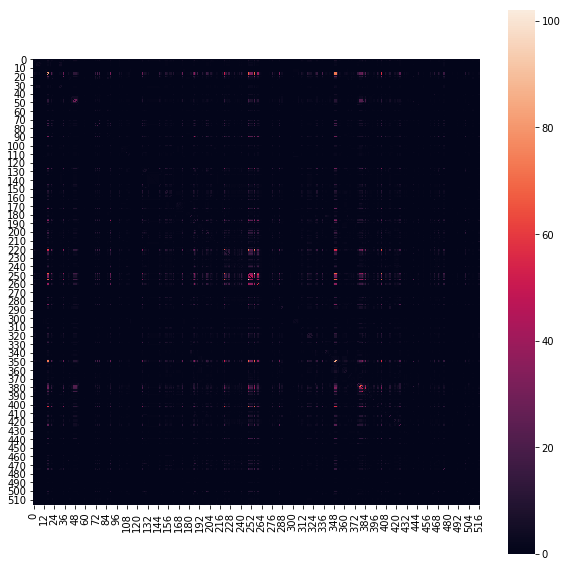

In [165]:
fig,ax = plt.subplots(figsize=(10,10))
sns.heatmap(kegg_pathway_counts.values, square=True)
plt.show()

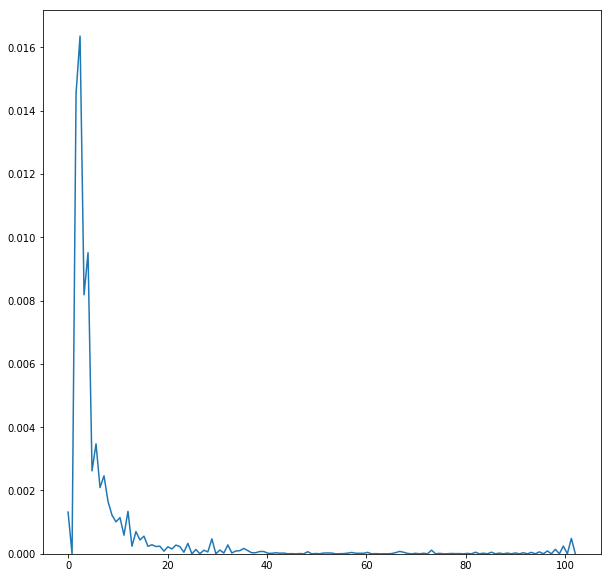

In [212]:
fig, ax = plt.subplots(figsize=(10,10))

__ = sns.kdeplot(kegg_pathway_counts.values.ravel())
plt.show()

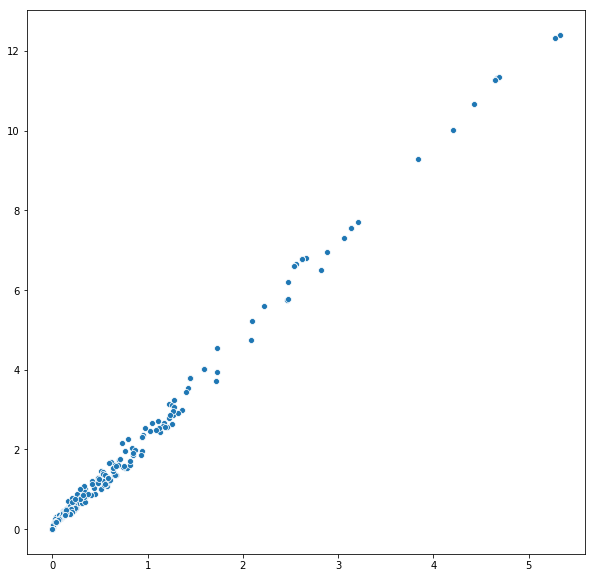

In [213]:
fig, ax = plt.subplots(figsize=(10,10))

mu = np.mean(kegg_pathway_counts_counts.values, axis=0)
s = np.std(kegg_pathway_counts.values, axis=0)

__ = sns.scatterplot(x=mu, y=s)
plt.show()

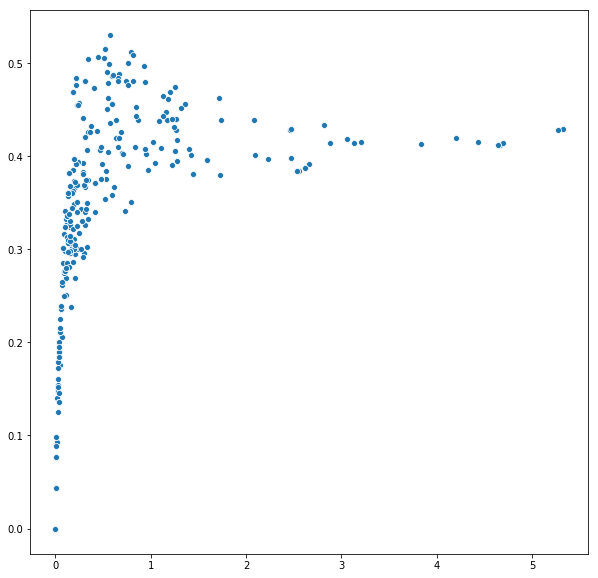

In [211]:
fig, ax = plt.subplots(figsize=(10,10))

mu = np.mean(kegg_pathway_counts.values, axis=0)
s = np.std(kegg_pathway_counts.values, axis=0)
np.place(s, s==0, 1.)

__ = sns.scatterplot(x=mu, y=mu/s)
plt.show()

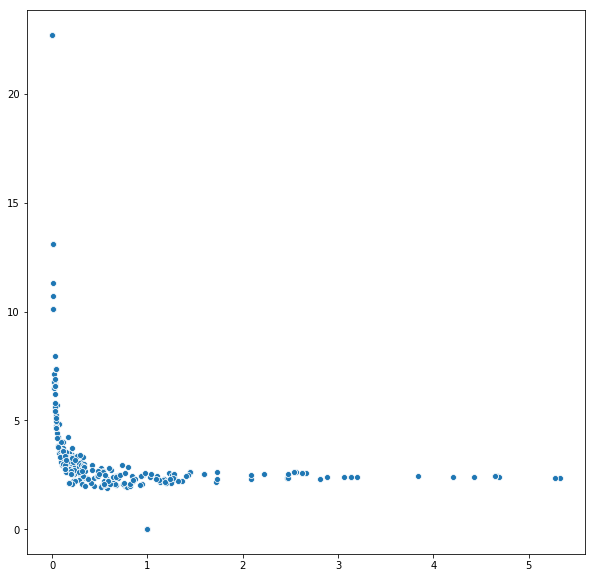

In [215]:
fig, ax = plt.subplots(figsize=(10,10))

mu = np.mean(kegg_pathway_counts.values, axis=0)
s = np.std(kegg_pathway_counts.values, axis=0)
np.place(mu, mu==0, 1.)

__ = sns.scatterplot(x=mu, y=s/mu)
plt.show()

In [162]:
t = copy(kegg_pathway_counts)
t['mean'] = np.mean(t.values, axis=0)
t.sort_values(by='mean', axis=0, inplace=True)
t = t.drop('mean', axis = 1)
t = t[t.index.to_list()]

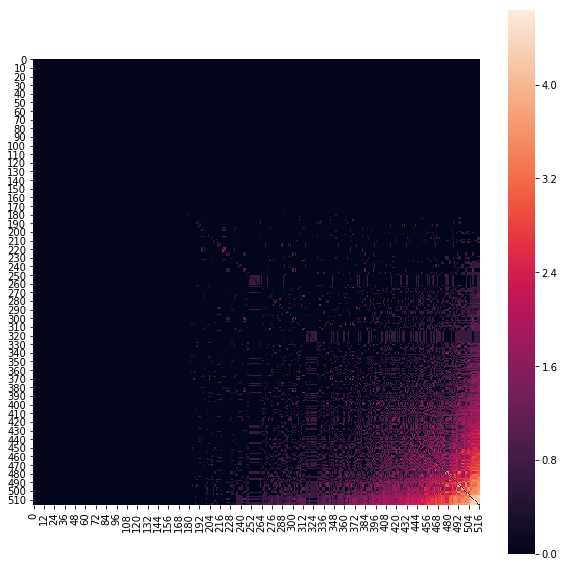

In [164]:
fig,ax = plt.subplots(figsize=(10,10))
sns.heatmap(np.log(t.values+1), square=True)
plt.show()

In [131]:
num_kinases_in_kegg = len(set([hgnc_mapper[gen] if gen in hgnc_mapper.keys() and hgnc_mapper[gen] in kin_set else None for path_set in iter(pathway_genes.values()) for gen in path_set]))-1
print(num_kinases_in_kegg)

343


In [167]:
kegg_pathway_counts.to_csv('../data/KEGG_pathway_coocccurence_counts.csv',header=True)

In [216]:
def anscombe(x):
    return 2*np.sqrt(x + .375)

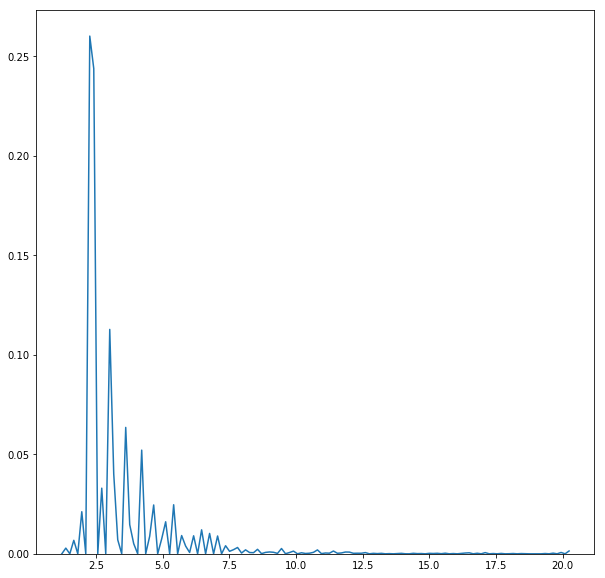

In [220]:
fig, ax = plt.subplots(figsize=(10,10))

__ = sns.kdeplot(np.apply_along_axis(anscombe,axis=0, arr=kegg_pathway_counts.values.ravel()))
plt.show()

In [223]:
kegg_pathway_counts.applymap(anscombe).to_csv('../data/anscombe_KEGG_counts.csv',header=True, sep='\t')

### Proceed to weight the network


In [3]:
kegg = pd.read_csv('../data/anscombe_KEGG_counts.csv', sep='\t', index_col=0, header=0)

display(network.head())
display(kegg.head())

,0,1
0,MST1R,YES1
1,TYRO3,YES1
2,FGR,SRC
3,ATR,FLT1
4,LYN,PRKCD


,AAK1,AATK,ABL1,ABL2,ACVR1,ACVR1B,ACVR1C,ACVR2A,ACVR2B,ACVRL1,...,VRK2,VRK3,WEE1,WEE2,WNK1,WNK2,WNK3,WNK4,YES1,ZAP70
AAK1,1.224745,1.224745,1.224745,1.224745,1.224745,1.224745,1.224745,1.224745,1.224745,1.224745,...,1.224745,1.224745,1.224745,1.224745,1.224745,1.224745,1.224745,1.224745,1.224745,1.224745
AATK,1.224745,1.224745,1.224745,1.224745,1.224745,1.224745,1.224745,1.224745,1.224745,1.224745,...,1.224745,1.224745,1.224745,1.224745,1.224745,1.224745,1.224745,1.224745,1.224745,1.224745
ABL1,1.224745,1.224745,1.224745,3.674235,1.224745,1.224745,1.224745,1.224745,1.224745,1.224745,...,1.224745,1.224745,2.345208,2.345208,1.224745,1.224745,1.224745,1.224745,1.224745,2.345208
ABL2,1.224745,1.224745,3.674235,1.224745,1.224745,1.224745,1.224745,1.224745,1.224745,1.224745,...,1.224745,1.224745,1.224745,1.224745,1.224745,1.224745,1.224745,1.224745,1.224745,2.345208
ACVR1,1.224745,1.224745,1.224745,1.224745,1.224745,3.674235,3.674235,4.183300,4.183300,2.345208,...,1.224745,1.224745,1.224745,1.224745,1.224745,1.224745,1.224745,1.224745,1.224745,1.224745


In [7]:
weights = []
for kin_0, kin_1 in zip(network[0], network[1]):
    weights.append(kegg.loc[kin_0, kin_1])
    
print(np.min(weights))
print(np.mean(weights))
print(np.max(weights))

1.224744871391589
2.92204703221355
20.236106344848057


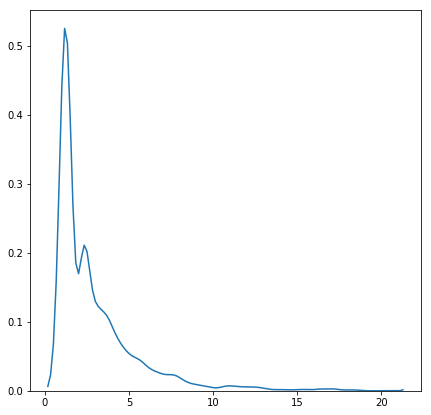

In [9]:
fig, ax = plt.subplots(figsize=(7,7))
sns.kdeplot(weights)
plt.show()

In [12]:
network[2] = weights
network.to_csv('../data/kin_anscombe_weighted.csv', sep='\t', header=False, index=False)